The primary goal of the International Consortium for Brain Mapping (ICBM) is to develop a probabilistic reference system for the human brain. The implementation of a data sharing space allows laboratories worldwide to make their own contribution to the ICBM evolving atlas.

# Setup and Libraries

In [14]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np
import nibabel as nib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and json for participants

In [15]:
DATASET_DIR = Path("/home/falconnier/Documents/dataset desktop/OMEGA/omega_data/")
DATASET_DIR = Path("/home/falconnier/Documents/dataset desktop/SCSDB")

In [16]:
# Check for README files in the dataset root and print their contents if found
readme_files = [
    p
    for p in DATASET_DIR.iterdir()
    if p.is_file() and p.name.lower().startswith("readme")
]

if readme_files:
    for rf in sorted(readme_files):
        print(f"--- {rf.name} ---")
        try:
            print(rf.read_text(encoding="utf-8"))
        except Exception as e:
            print(f"Failed to read {rf}: {e}")
else:
    display(f"No README file found at {DATASET_DIR}.")

--- README ---
The dataset contains structural T1-weighted magnetic resonance brain imaging data from 136 young individuals (87 females; age range from 18 to 35 years old) along with questionnaire-assessed measurements of trait-like chronotype, sleep quality and daytime sleepiness. The recruitment criteria excluded individuals with self-reported history of psychiatric or neurological conditions and current medication use. All the brain imaging sessions were performed between 5:20 PM and 8:55 PM in order to control the effect of time of day on acquired images. The data is mostly useful to scientists interested in circadian rhythmicity. It can be deployed in large-scale multicenter meta-analyses investigating the structural brain correlates of chronotypes in humans. Additionally, the data could be of use in investigations into the effects of sleeping habits and latitude on brain anatomy.


In [17]:
json_path = DATASET_DIR / "participants.json"

# Safely open and load the JSON file if it exists
if json_path.exists():
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        # Print the JSON content (pretty-printed)
        print(json.dumps(data, indent=4))
    except Exception as e:
        print(f"Failed to load JSON file {json_path}: {e}")
        data = {}
else:
    print(f"No JSON file found at {json_path}. Continuing without JSON.")
    data = {}

{
    "age": {
        "Description": "age of the participant",
        "Units": "years"
    },
    "sex": {
        "Description": "sex of the participant as reported by the participant",
        "Levels": {
            "M": "male",
            "F": "female"
        }
    },
    "group": {
        "Description": "experimental group the participant was classified to",
        "Levels": {
            "EC": "early chronotype, ChQ-ME 11 - 21",
            "LC": "late chronotype, ChQ-ME 22 - 32"
        }
    },
    "ChQ-ME": {
        "Description": "morningness-eveningness scale of Chronotype Questionnaire (Oginska et al., 2011, 2017)",
        "Units": "points"
    },
    "ChQ-AM": {
        "Description": "amplitude scale of Chronotype Questionnaire (Oginska et al., 2011, 2017)",
        "Units": "points"
    },
    "PSQI": {
        "Description": "overall score in Pittsburgh Sleep Quality Index (Buysse et al., 1989)",
        "Units": "points"
    },
    "ESS": {
        "Description

In [18]:
csv_path = DATASET_DIR / "participants.tsv"
df = pd.read_csv(DATASET_DIR / "participants.tsv", sep="\t")
print(df.columns)

Index(['participant_id', 'age', 'sex', 'group', 'ChQ-ME', 'ChQ-AM', 'PSQI',
       'ESS', 'Published', 'L_Ent/FFG_CTh'],
      dtype='object')


In [19]:
# little adjustments
# Convert categorical variables
categorical_cols = [
    "participant_id",
    "sex",
    "handedness",
    "group",
    "sessions",
    "recordings",
    "anatomy",
    "questionnaires",
]

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Replace impossible values
df["age"] = df["age"].replace(0, np.nan)

df.head()


,participant_id,age,sex,group,ChQ-ME,ChQ-AM,PSQI,ESS,Published,L_Ent/FFG_CTh
0,sub-02,33,M,EC,19,17,4,4,Yes,2.221920
1,sub-03,22,M,EC,17,16,3,11,No,NaN
2,sub-04,26,F,EC,20,20,1,10,Yes,2.612423
3,sub-05,28,F,LC,23,20,7,13,No,NaN
4,sub-07,27,M,EC,21,16,4,8,Yes,2.528243


# Basic descriptions

In [20]:
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))


print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))


print("\n=== Categorical Features Summary ===")
display(df.describe(include=["category", "object"]))


missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)

missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("=== Missing Values by Column ===")
display(missing_df)


=== Columns in the Dataset ===


,Column Names
0,participant_id
1,age
2,sex
3,group
4,ChQ-ME
5,ChQ-AM
6,PSQI
7,ESS
8,Published
9,L_Ent/FFG_CTh



=== Numeric Features Summary ===


,age,ChQ-ME,ChQ-AM,PSQI,ESS,L_Ent/FFG_CTh
count,136.00,136.00,136.00,136.00,136.00,113.00
mean,24.33,21.72,20.81,3.07,7.07,2.80
std,3.73,5.63,3.74,1.40,3.51,0.34
min,18.00,11.00,11.00,0.00,0.00,2.15
25%,22.00,17.00,18.00,2.00,5.00,2.55
50%,23.00,21.50,21.00,3.00,7.00,2.75
75%,26.00,27.00,24.00,4.00,9.00,3.01
max,35.00,32.00,29.00,9.00,17.00,3.77



=== Categorical Features Summary ===


,participant_id,sex,group,Published
count,136,136,136,136
unique,136,2,2,2
top,sub-02,F,EC,Yes
freq,1,87,68,113


=== Missing Values by Column ===


,Missing Count,Missing %
L_Ent/FFG_CTh,23,16.91
participant_id,0,0.00
age,0,0.00
sex,0,0.00
ChQ-ME,0,0.00
group,0,0.00
ChQ-AM,0,0.00
PSQI,0,0.00
ESS,0,0.00
Published,0,0.00


# Histograms

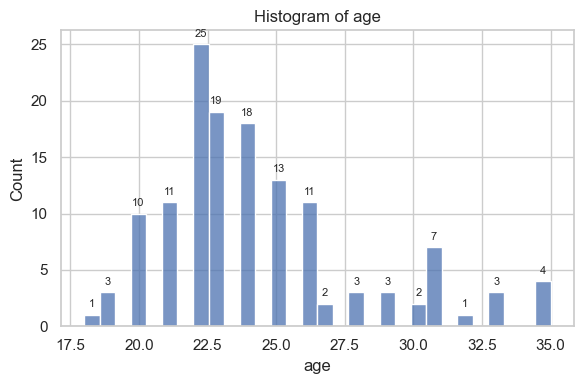

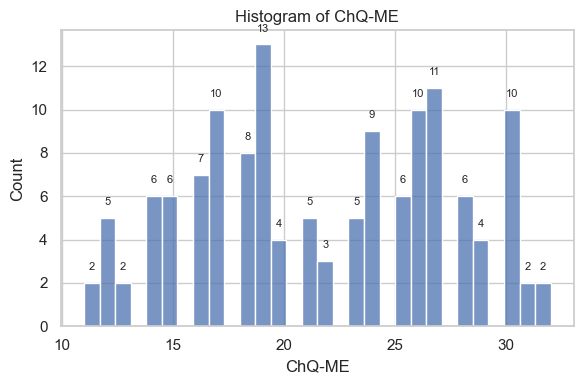

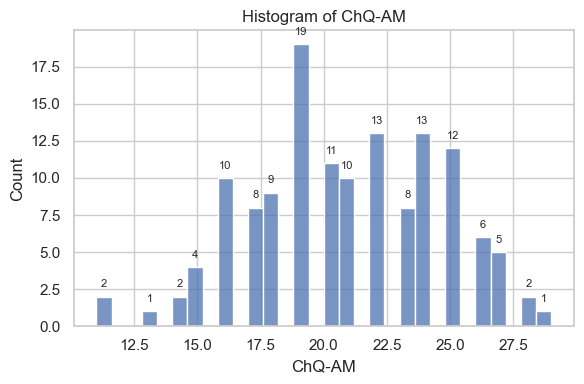

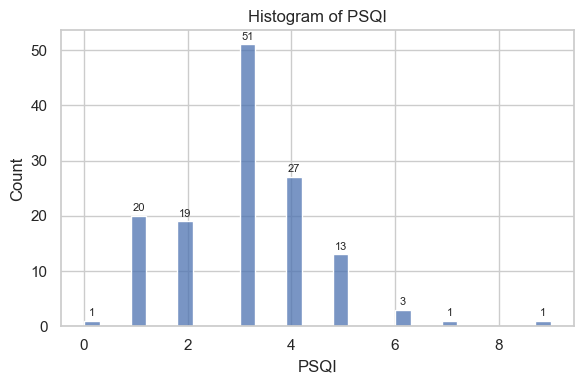

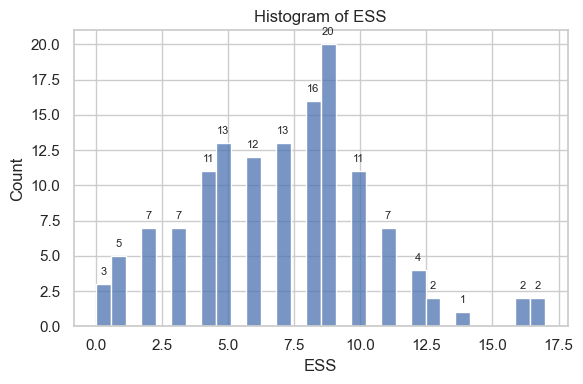

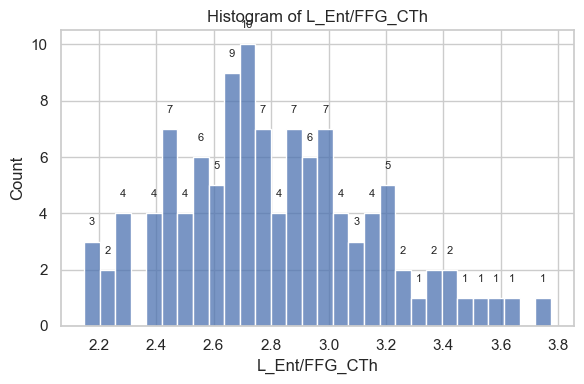

In [21]:
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    ax = sns.histplot(df[col].dropna(), bins=30, kde=False)

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            ax.text(
                patch.get_x() + patch.get_width() / 2,
                height + 0.5,
                int(height),
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.tight_layout()
    plt.show()


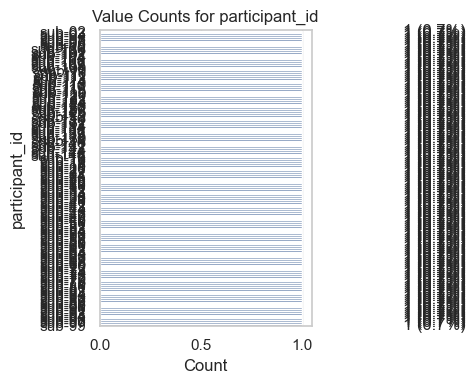

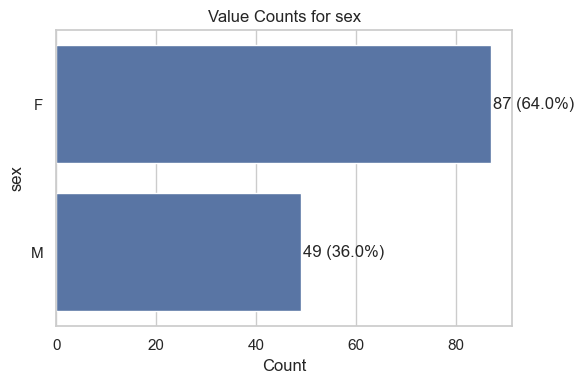

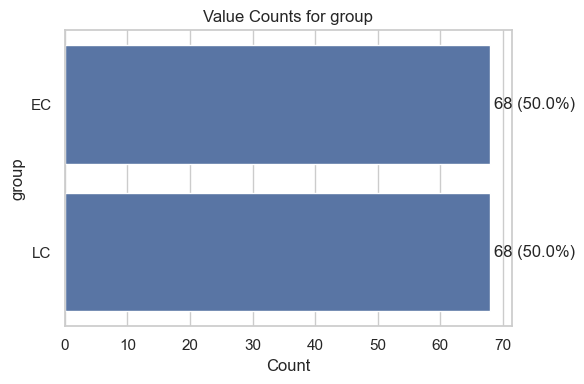

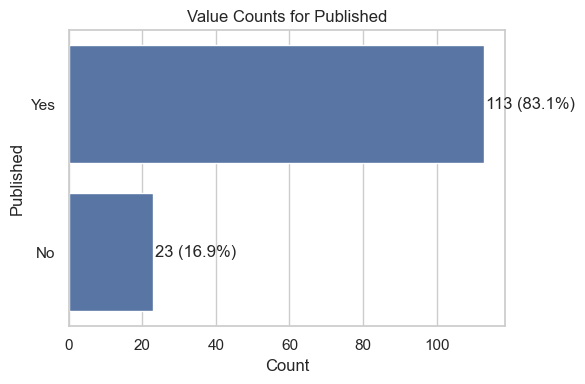

In [22]:
categorical_cols = df.select_dtypes(include=["category", "object"]).columns

for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


In [ ]:
if "sessions" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x="sessions", data=df, order=sorted(df["sessions"].dropna().unique()))
    plt.title("Number of Sessions per Participant")
    plt.xlabel("Sessions")
    plt.ylabel("Number of Participants")
    plt.tight_layout()
    plt.show()
if "recordings" in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        x="recordings", data=df, order=sorted(df["recordings"].dropna().unique())
    )
    plt.title("Number of Recordings per Participant")
    plt.xlabel("Recordings")
    plt.ylabel("Number of Participants")
    plt.tight_layout()
    plt.show()


# anat analysis

Scan for nifti files

In [27]:
anat_files = list(DATASET_DIR.rglob("anat/*.nii*"))
print(f"Found {len(anat_files)} anatomical files.")


Found 136 anatomical files.


In [28]:
data = []

for fpath in anat_files:
    fname = fpath.name

    # Extract participant, session, modality from BIDS filename
    parts = fname.split("_")
    sub_id = next((p.split("-")[1] for p in parts if p.startswith("sub-")), None)
    ses_id = next((p.split("-")[1] for p in parts if p.startswith("ses-")), None)
    modality = next(
        (p.replace(".nii.gz", "") for p in parts if p.endswith(".nii.gz")), None
    )  # T1w, T2w

    # Load NIfTI header
    img = nib.load(fpath)
    header = img.header
    voxel_sizes = header.get_zooms()  # voxel dimensions (x, y, z)
    shape = img.shape  # (x, y, z)

    # Compute slice thickness (z voxel dimension)
    slice_thickness = voxel_sizes[2] if len(voxel_sizes) >= 3 else None
    z_size = shape[2] if len(shape) >= 3 else None

    # Store in dictionary
    data.append(
        {
            "participant_id": sub_id,
            "session_id": ses_id,
            "modality": modality,
            "file_path": str(fpath),
            "voxel_size_x": voxel_sizes[0],
            "voxel_size_y": voxel_sizes[1],
            "voxel_size_z": voxel_sizes[2] if len(voxel_sizes) >= 3 else None,
            "slice_thickness": slice_thickness,
            "x_dim": shape[0],
            "y_dim": shape[1],
            "z_dim": z_size,
        }
    )


In [29]:
df_anat = pd.DataFrame(data)
print(f"Summary dataframe shape: {df_anat.shape}")
df_anat.head()


Summary dataframe shape: (136, 11)


,participant_id,session_id,modality,file_path,voxel_size_x,voxel_size_y,voxel_size_z,slice_thickness,x_dim,y_dim,z_dim
0,54,None,T1w,/home/falconnier/Documents/dataset desktop/SCS...,1.100000,1.0,1.0,1.0,176,248,256
1,64,None,T1w,/home/falconnier/Documents/dataset desktop/SCS...,1.099998,1.0,1.0,1.0,176,248,256
2,19,None,T1w,/home/falconnier/Documents/dataset desktop/SCS...,1.099998,1.0,1.0,1.0,176,248,256
3,57,None,T1w,/home/falconnier/Documents/dataset desktop/SCS...,1.099998,1.0,1.0,1.0,176,248,256
4,146,None,T1w,/home/falconnier/Documents/dataset desktop/SCS...,1.100000,1.0,1.0,1.0,176,248,256


In [30]:
# Count of modalities
print("Modality Counts:")
print(df_anat["modality"].value_counts())

# Slice thickness statistics
print("\nSlice Thickness Statistics:")
print(df_anat["slice_thickness"].describe().round(2))

# Z dimension statistics
print("\nZ Dimension Statistics:")
print(df_anat["z_dim"].describe())


Modality Counts:
modality
T1w    136
Name: count, dtype: int64

Slice Thickness Statistics:
count    136.00
mean       1.00
std        0.01
min        0.92
25%        1.00
50%        1.00
75%        1.00
max        1.03
Name: slice_thickness, dtype: float64

Z Dimension Statistics:
count    136.0
mean     256.0
std        0.0
min      256.0
25%      256.0
50%      256.0
75%      256.0
max      256.0
Name: z_dim, dtype: float64
